In [2]:
# benchmark_parent_filter_child_scores.py
import math
import torch
import triton
import triton.testing as tt

import sys

sys.path.append("..")

from hira.kernels.triton_wrappers import triton_two_level_filter
from generate_level import generate_parent_child_structure

In [3]:
# CONFIG
n = 90000
dim = 128
dtype = torch.float32
B = 256
blocks = 64
distribution = "real"
target_count = 10
device = "cuda"

### Baselines to compare

In [4]:
# ----------------------------
# PyTorch reference baseline
# ----------------------------
@torch.no_grad()
def torch_baseline(K, P, R, q, t):
    scores = K @ q  # (n,)
    return scores


@torch.no_grad()
def torch_parent_child_filter(
    K: torch.Tensor,  # [N, D]
    P: torch.Tensor,  # [Kp, D]
    R: torch.Tensor,  # [Kp]
    q: torch.Tensor,  # [D]
    t: float,  # scalar
    branching_factor: int,
    out: torch.Tensor | None,  # [N] optional
    zero_out: bool = True,
):
    device = K.device
    N, D = K.shape
    num_parents = P.shape[0]
    assert num_parents * branching_factor <= N

    # passes: [Kp]
    parent_dot = P @ q  # [Kp]
    passes = (parent_dot + R) > t  # bool [Kp]

    # scores for first Kp*B rows only (the ones the kernel ever writes)
    M = num_parents * branching_factor
    scores = K[:M] @ q  # [M]

    # Build a per-child mask: repeat each parent pass flag B times
    child_mask = passes.repeat_interleave(branching_factor)  # [M]

    # Only write where mask is True (matches kernel: only stores for passing parents)
    out[:M][child_mask] = scores[child_mask]

    return out

# Benchmark Parent-Child Filter Kernel

In [7]:
from generate_level import compute_halfspace_statistics

# Generate structure
K, P, R = generate_parent_child_structure(
    num_keys=n,
    dim=dim,
    branching_factor=B,
    distribution=distribution,
    seed=42,
    device="cpu",
    real_data_path="../kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz",
)

# Generate a random query
q = torch.randn(dim)
q = q / q.norm()

# Compute parent scores for threshold selection
all_scores = K @ q
sorted_scores, _ = torch.sort(all_scores, descending=True)
threshold = sorted_scores[min(target_count, len(sorted_scores) - 1)].item()

stats = compute_halfspace_statistics(K, P, R, q, threshold, branching_factor=B)

print(f"    Threshold: {threshold:.4f}")
print(
    f"    Parents passing: {stats['parents_passing']}/{stats['parents_total']} ({stats['parents_pass_rate']*100:.1f}%)"
)
print(
    f"    Children evaluated: {stats['children_evaluated']}/{stats['children_total']} ({stats['children_pass_rate']*100:.1f}%)"
)

  Loaded 90000 real keys (dimension=128)
    Threshold: 3.9917
    Parents passing: 326/352 (92.6%)
    Children evaluated: 83456/90112 (92.6%)


In [10]:
# ----------------------------
# Benchmark function (no decorator)
# ----------------------------
def run_benchmark(
    n, provider, BLOCK_C, n_warps, target_count, dtype, distribution, branch
):
    torch.manual_seed(0)

    K_cpu, P_cpu, R_cpu = generate_parent_child_structure(
        num_keys=n,
        dim=dim,
        branching_factor=branch,
        distribution=distribution,
        seed=0,
        device="cpu",  # Generate on CPU first
        real_data_path="../kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz",
    )

    # Move to GPU and convert dtype
    K = K_cpu.to(device=device, dtype=dtype)
    P = P_cpu.to(device=device, dtype=dtype)
    R = R_cpu.to(device=device, dtype=dtype)

    # Generate query vector
    q = torch.randn((dim,), device=device, dtype=dtype)
    q = q / (q.norm(p=2) + 1e-12)

    all_scores = K @ q
    sorted_scores, _ = torch.sort(all_scores, descending=True)
    t = sorted_scores[min(target_count, len(sorted_scores) - 1)].item()

    # output buffer (pre-zeroed each timed run)
    out = torch.zeros((n,), device=device, dtype=dtype)

    # Warmups to exclude JIT + cache effects (like tutorials)
    if provider == "triton":
        for _ in range(10):
            out.zero_()
            triton_two_level_filter(
                K, P, R, q, t, BLOCK_C=BLOCK_C, n_warps=n_warps, out=out, branch=branch
            )
        torch.cuda.synchronize()
        out.zero_()

        def run():
            triton_two_level_filter(
                K, P, R, q, t, BLOCK_C=BLOCK_C, n_warps=n_warps, out=out, branch=branch
            )

        ms = tt.do_bench(run, warmup=10, rep=100)
        return ms * 1e3

    elif provider == "torch":
        for _ in range(10):
            _ = torch_baseline(K, P, R, q, t)
        torch.cuda.synchronize()

        ms = tt.do_bench(lambda: torch_baseline(K, P, R, q, t), warmup=10, rep=100)
        return ms * 1e3
    elif provider == "torch_pc_filter":
        for _ in range(10):
            out.zero_()
            torch_parent_child_filter(
                K, P, R, q, t, branching_factor=branch, out=out, zero_out=True
            )
        torch.cuda.synchronize()
        out.zero_()

        ms = tt.do_bench(
            lambda: torch_parent_child_filter(
                K, P, R, q, t, branching_factor=branch, out=out, zero_out=True
            ),
            warmup=10,
            rep=100,
        )
        return ms * 1e3
    else:
        raise ValueError("provider must be triton or torch")

## Run Benchmarks

#### Different n, branch, block_c

  Loaded 10000 real keys (dimension=128)
  Loaded 10000 real keys (dimension=128)
  Loaded 10000 real keys (dimension=128)
  Loaded 10000 real keys (dimension=128)
  Loaded 10000 real keys (dimension=128)
  Loaded 10000 real keys (dimension=128)
  Loaded 10000 real keys (dimension=128)
  Loaded 10000 real keys (dimension=128)
  Loaded 10000 real keys (dimension=128)
  Loaded 10000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 r

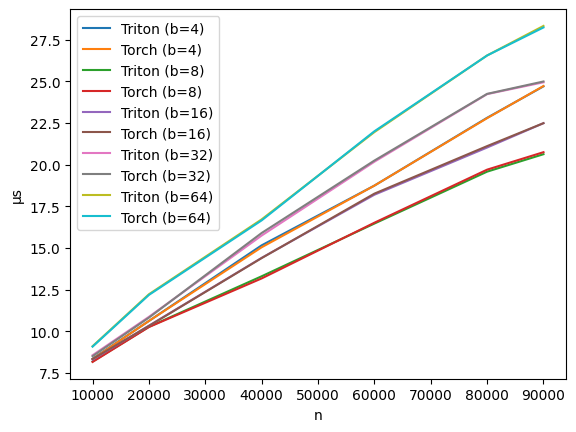

parent_filter_child_scores_real:
         n  Triton (b=4)  Torch (b=4)  Triton (b=8)  Torch (b=8)  Triton (b=16)  Torch (b=16)  Triton (b=32)  Torch (b=32)  Triton (b=64)  Torch (b=64)
0  10000.0      8.351214     8.327948      8.182162     8.160414       8.298529      8.336155       8.560935      8.503884       9.103221      9.078494
1  20000.0     10.618649    10.620695     10.268915    10.254228      10.336417     10.321655      10.866592     10.820105      12.223476     12.183502
2  40000.0     15.158865    15.042613     13.301650    13.172325      14.407093     14.394240      15.747140     15.900141      16.717591     16.657538
3  60000.0     18.744381    18.742476     16.464970    16.515933      18.195918     18.261878      20.177649     20.247588      21.954899     22.005072
4  80000.0     22.814665    22.792418     19.581628    19.701589      21.030211     21.115128      24.234555     24.251397      26.557034     26.553968
5  90000.0     24.701871    24.720757     20.628323    

<Figure size 640x480 with 0 Axes>

In [11]:
branches = [4, 8, 16, 32, 64]
providers = ["triton", "torch"]

line_vals = [f"triton_b{b}" for b in branches for p in providers]
line_names = [f"{p.title()} (b={b})" for b in branches for p in providers]


@tt.perf_report(
    tt.Benchmark(
        x_names=["n"],
        x_vals=[10000, 20000, 40000, 60000, 80000, 90000],
        line_arg="case",
        line_vals=line_vals,
        line_names=line_names,
        ylabel="µs",
        plot_name=f"parent_filter_child_scores_{distribution}",
        args={
            "n_warps": 4,
            "dtype": dtype,
            "distribution": distribution,
            "target_count": target_count,
        },
    )
)
def benchmark_wrapper(n, case, n_warps, target_count, dtype, distribution):
    provider, bpart = case.split("_b")
    branch = int(bpart)
    BLOCK_C = branch

    return run_benchmark(
        n, provider, BLOCK_C, n_warps, target_count, dtype, distribution, branch
    )


benchmark_wrapper.run(print_data=True, show_plots=True, save_path="./reports")

  Loaded 10000 real keys (dimension=128)
  Loaded 10000 real keys (dimension=128)
  Loaded 10000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 20000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 60000 real keys (dimension=128)
  Loaded 60000 real keys (dimension=128)
  Loaded 60000 real keys (dimension=128)
  Loaded 80000 real keys (dimension=128)
  Loaded 80000 real keys (dimension=128)
  Loaded 80000 real keys (dimension=128)
  Loaded 90000 real keys (dimension=128)
  Loaded 90000 real keys (dimension=128)
  Loaded 90000 real keys (dimension=128)


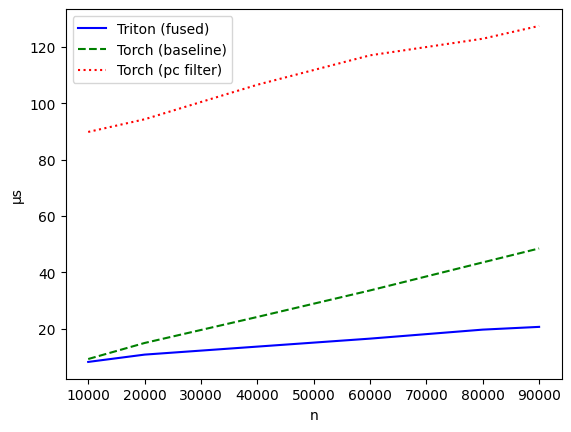

parent_filter_child_scores_real_ns:
         n  Triton (fused)  Torch (baseline)  Torch (pc filter)
0  10000.0        8.213506          9.241892          89.813309
1  20000.0       10.805646         14.930133          94.300993
2  40000.0       13.647152         24.164508         106.551961
3  60000.0       16.477722         33.574098         116.998758
4  80000.0       19.674713         43.522545         122.887724
5  90000.0       20.648762         48.481740         127.430262


<Figure size 640x480 with 0 Axes>

In [12]:
@tt.perf_report(
    tt.Benchmark(
        x_names=["n"],  # sweep n
        x_vals=[10000, 20000, 40000, 60000, 80000, 90000],
        line_arg="provider",
        line_vals=["triton", "torch", "torch_pc_filter"],
        line_names=["Triton (fused)", "Torch (baseline)", "Torch (pc filter)"],
        styles=[("blue", "-"), ("green", "--"), ("red", ":")],
        ylabel="µs",
        plot_name=f"parent_filter_child_scores_{distribution}_ns",
        args={
            "n_warps": 4,
            "dtype": dtype,
            "distribution": distribution,
            "target_count": target_count,
            "branch": 8,
            "BLOCK_C": 8,
        },
    )
)
def benchmark_wrapper(
    n, provider, BLOCK_C, n_warps, target_count, dtype, distribution, branch
):
    return run_benchmark(
        n, provider, BLOCK_C, n_warps, target_count, dtype, distribution, branch
    )


# Run the benchmark
benchmark_wrapper.run(print_data=True, show_plots=True, save_path="./reports")

  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)
  Loaded 40000 real keys (dimension=128)


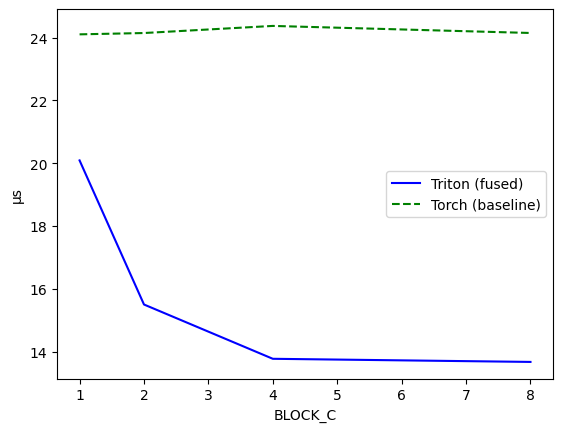

parent_filter_child_scores_real_2:
   BLOCK_C  Triton (fused)  Torch (baseline)
0      1.0       20.089100         24.102611
1      2.0       15.501462         24.144587
2      4.0       13.773183         24.370801
3      8.0       13.673605         24.146087


<Figure size 640x480 with 0 Axes>

In [8]:
@tt.perf_report(
    tt.Benchmark(
        x_names=["BLOCK_C"],  # sweep n
        x_vals=[1, 2, 4, 8],
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton (fused)", "Torch (baseline)"],
        styles=[("blue", "-"), ("green", "--")],
        ylabel="µs",
        plot_name=f"parent_filter_child_scores_{distribution}_2",
        args={
            "n": 40000,
            "n_warps": 4,
            "dtype": dtype,
            "distribution": distribution,
            "target_count": target_count,
            "branch": 8,
        },
    )
)
def benchmark_wrapper(
    n, provider, BLOCK_C, n_warps, target_count, dtype, distribution, branch
):
    return run_benchmark(
        n, provider, BLOCK_C, n_warps, target_count, dtype, distribution, branch
    )


# Run the benchmark
benchmark_wrapper.run(print_data=True, show_plots=True, save_path="./reports")